# Importance sampling to get sufficient coverage of the RGB

First I will test different KDE implementations to apply the weights and get everything working fast

In [3]:
"""
This script prepares a Gaia DR3 catalog for the Bayesian KDE classifier.
It reads a Gaia DR3 catalog, and computes the implied quantities.
The script also adds extinction corrections and computes the implied 
absolute magnitude. The output is a pandas dataframe with the Gaia DR3 
catalog ready for the Bayesian KDE classifier.
"""
# Standard library imports
import os
import sys
import random

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as colors
from matplotlib.gridspec import GridSpec

from scipy.optimize import minimize
import healpy as hp
from numba import njit

# Astropy imports
from astropy.io import fits
from astropy.table import Table, vstack
from astropy import units as u
from astropy.constants import kpc, au
from astropy.coordinates import (
    SkyCoord,
    Galactocentric,
    ICRS,
    CartesianRepresentation,
    CartesianDifferential,
)
from astropy.coordinates.matrix_utilities import (
    rotation_matrix,
    matrix_product,
    matrix_transpose,
)

# Custom script imports
sys.path.append('/Users/mncavieres/Documents/2024-2/HVS')  # Add scripts folder to path
from scripts.implied_d_vr import *  # Import specific functions or classes as needed
from scripts.selections import *
from scripts.CMD_selection import *
from scripts.catalog_preparation.prepare_gaia import *


# Load and prepare Gaia data

This implies opening a catalog, computing the implied distance, radial velocity and extinction correction

In [4]:
# load the Gaia DR3 catalog    
data_gaia_big = pd.read_feather('/Users/mncavieres/Documents/2024-2/HVS/Data/Gaia_tests/200pc/raw_gaia_catalog/3M_sources_goodruwe.feather')
data_gaia_big['bp_rp'] = data_gaia_big['phot_bp_mean_mag'] - data_gaia_big['phot_rp_mean_mag']

In [5]:
data_gaia_prepared = prepare_gaia(data_gaia_big)

/Users/mncavieres/Documents/2024-2/HVS/scripts/selections.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  catalog['A_G'] = A_G
/Users/mncavieres/Documents/2024-2/HVS/scripts/selections.py:271: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  catalog['A_bp'] = A_bp
/Users/mncavieres/Documents/2024-2/HVS/scripts/selections.py:272: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

## Apply initial filters on the Gaia data

The initial filters are that the implied parallax and the measured parallax are consistent, and that the implied radial velocity of the star is reasonable for a HVS, this means that it is going away from the galactic center at more than a couple hundred km/s.

In [23]:
data_gaia_prepared = data_gaia_prepared.loc[parallax_consistency(data_gaia_prepared.parallax, 
                                                                 data_gaia_prepared.parallax_error, 
                                                                 data_gaia_prepared.implied_parallax,
                                                                 data_gaia_prepared.implied_parallax_error)]

In [69]:
data_gaia_prepared.columns

Index(['source_id', 'l', 'b', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax',
       'parallax_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error',
       'astrometric_params_solved', 'astrometric_excess_noise',
       'astrometric_excess_noise_sig', 'ruwe', 'pseudocolour',
       'nu_eff_used_in_astrometry', 'pseudocolour', 'ecl_lat',
       'phot_g_mean_mag', 'phot_g_mean_flux', 'phot_bp_mean_mag',
       'phot_bp_mean_flux', 'phot_rp_mean_mag', 'phot_rp_mean_flux',
       'phot_bp_rp_excess_factor', 'bp_rp', 'implied_parallax',
       'implied_parallax_error', 'VGCR', 'VR', 'A_G', 'A_bp', 'A_rp', 'G_corr',
       'phot_bp_mean_mag_corr', 'phot_rp_mean_mag_corr', 'bp_rp_corr',
       'implied_M_g', 'implied_M_g_corr', 'implied_M_g_corr_error'],
      dtype='object')

In [24]:
data_gaia_prepared = data_gaia_prepared.loc[is_fast(data_gaia_prepared.VGCR, lower_limit=300)]

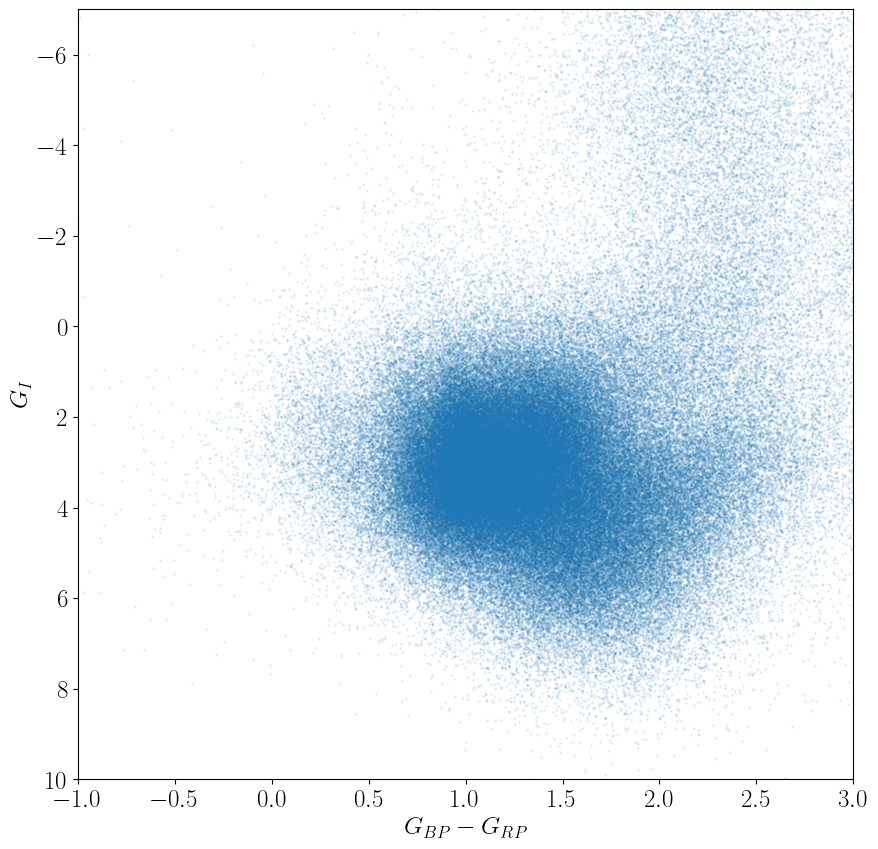

In [25]:
# plot the CMD of the data
plt.figure(figsize=(10, 10))
plt.scatter(data_gaia_prepared['bp_rp'], data_gaia_prepared['implied_M_g_corr'], s=1, alpha=0.1)
plt.gca().invert_yaxis()
plt.xlabel('$G_{BP} - G_{RP}$')
plt.ylabel('$G_I$')
plt.xlim(-1, 3)
plt.ylim(10, -7)
plt.show()

# Load and prepare speedystar catalog

In [26]:
#speedystar = Table.read('/Users/mncavieres/Documents/2024-2/HVS/Data/speedystar_catalogs/speedy_flat.fits')
#speedystar = pd.read_csv('/Users/mncavieres/Documents/2024-2/HVS/Data/speedystar_catalogs/stock.csv')
#speedystar = Table.from_pandas(speedystar)
speedystar = Table.read('/Users/mncavieres/Documents/2024-2/HVS/Data/speedystar_catalogs/stock_long.fits')
#speedystar = speedystar.to_pandas()

In [27]:
speedystar = prepare_speedystar(speedystar)

/Users/mncavieres/opt/anaconda3/envs/speedytest2/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Test fit a KDE with weights

In [28]:
from sklearn.neighbors import KernelDensity

In [49]:
# define weights for the KDE based on an IMF, of salpeter slope
def imf_weights(mass, mass_min=0.5, mass_max=100, alpha=2.35):
    norm = (1 - alpha) / (mass_max**(1-alpha) - mass_min**(1-alpha))
    return norm * mass**(-alpha)

# define weigths for the KDE based on Logg, weighting low logg stars more
def logg_weights(logg, logg_min=0, logg_max=5):
    norm = 1 / (logg_max - logg_min)
    return norm * (logg_max - logg)

# define weights for the KDE based on stage of evolution, weighting dwarfs evolved stars more, if the stage is more than 4.1 truncates the weight to 1

def stage_weights(stage, stage_max=4.1):
    norm = 1 / stage_max
    return np.where(stage > stage_max, 1.0, norm * (stage_max - stage))

def stage_weights2(stage, stage_max=4.1):
    norm = 1 / stage_max
    return np.where(stage > stage_max, 0.0, norm *  (stage))

def stage_weights_power(stage, stage_max=4.1, power=2.0):
    """
    Compute weights that emphasize higher stages more than a linear scale.
    Stages are normalized to [0, 1] by dividing by stage_max, then raised to a power.
    Increasing 'power' (>1) skews the weights so that higher stages get a much larger share.

    Parameters
    ----------
    stage : array-like
        Array of stage values.
    stage_max : float
        Maximum stage value that maps to weight = 1.
    power : float
        Exponent controlling the nonlinearity of the weighting.
        Values > 1 emphasize higher stages more.

    Returns
    -------
    weights : array-like
        Weights of the same shape as stage, emphasizing higher stages.
    """
    normalized = stage / stage_max
    weights = np.where(stage > stage_max, 0.0, normalized**power)
    return weights

def stage_weights(stage, stage_max=4.1, type='power', power=2.0):
    """
    Compute stage-based weights using a chosen non-linear transformation.

    Parameters
    ----------
    stage : array-like
        Array of stage values.
    stage_max : float
        Maximum stage value that maps to weight = 1.
    type : {'power', 'sqrt', 'log', 'exp'}
        The type of non-linear transformation to apply.
        - 'power': (stage/stage_max)**power
        - 'sqrt': sqrt(stage/stage_max)
        - 'log': log1p(stage)/log1p(stage_max)
        - 'exp': (exp(stage/stage_max)-1)/(exp(1)-1)
    power : float
        Exponent used if type='power'. Default is 2.0.
    
    Returns
    -------
    weights : ndarray
        Weights of the same shape as `stage`, transformed according to `type`.
    """

    stage = np.asarray(stage)
    
    # Handle stages beyond stage_max
    # These get zero weight
    mask = stage <= stage_max
    weights = np.zeros_like(stage, dtype=float)

    # Normalize stage to [0, 1]
    normalized = np.zeros_like(stage, dtype=float)
    normalized[mask] = stage[mask] / stage_max

    # Apply chosen transformation
    if type == 'power':
        # (stage/stage_max)**power
        weights[mask] = normalized[mask]**power
    elif type == 'sqrt':
        # sqrt(stage/stage_max)
        weights[mask] = np.sqrt(normalized[mask])
    elif type == 'log':
        # log1p(stage)/log1p(stage_max)
        # ensures 0 maps to 0 and stage_max maps to 1
        # if stage_max is large, log scaling spreads out values
        weights[mask] = np.log1p(stage[mask]) / np.log1p(stage_max)
    elif type == 'exp':
        # (exp(stage/stage_max)-1)/(e-1)
        # ensures 0 maps to 0 and stage_max maps to 1
        weights[mask] = (np.exp(normalized[mask]) - 1.0) / (np.e - 1.0)
    else:
        raise ValueError("Invalid type. Supported types: 'power', 'sqrt', 'log', 'exp'.")

    return weights


def weights_new_imf(mass, alpha_i=2.3, alpha_new=4.3):
    """
    Computes weights to transform samples drawn from an initial IMF with slope alpha_i
    into one that mimics an IMF with slope alpha_new, and rescales them to [0, 1].

    The initial IMF is proportional to M^-alpha_i, and the new one to M^-alpha_new.
    The required weighting factor is proportional to M^(alpha_i - alpha_new).

    Parameters
    ----------
    mass : array-like
        Array of stellar masses.
    alpha_i : float
        Slope of the initial IMF.
    alpha_new : float
        Slope of the new IMF we want to mimic.

    Returns
    -------
    weights : ndarray
        An array of weights scaled between 0 and 1.
    """
    mass = np.asarray(mass)

    # Compute the pre-normalized weights
    weights_pre_norm = mass ** (alpha_i - alpha_new)

    # Perform min-max scaling to [0, 1]
    w_min = weights_pre_norm.min()
    w_max = weights_pre_norm.max()

    # If all weights are equal, they are all the same mass or ratio,
    # scaling would lead to divide by zero. In that case, just return zeros.
    if w_max == w_min:
        return np.zeros_like(weights_pre_norm)

    weights_scaled = (weights_pre_norm - w_min) / (w_max - w_min)

    return weights_scaled


def change_imf_weights(mass, alpha_ini, alpha_new, min_mass = 0.5, max_mass = 1e4):

    weight=  mass**(alpha_ini - alpha_new)
    # normalize weights
    weights = weight/np.max(weight)

    # truncate the weights within the given mass range
    weights = np.where(mass < min_mass, 1, weight)
    weights = np.where(mass > max_mass, 0, weights)

    return weights




In [31]:
# select only objects that could be in the DR3 catalog
speedystar = speedystar.loc[speedystar['phot_g_mean_mag'] < 21]

In [50]:
speedystar['weights'] = stage_weights2(speedystar['stage'])
speedystar['weight_power'] = stage_weights(speedystar['stage'], type='power', power=2.0)
speedystar['weight_imf_0'] = change_imf_weights(speedystar['m'], alpha_ini= 2.3, alpha_new= 0)

In [40]:
# select only point sbetween bp-rp = -1 and 3 and G_I = 10 and -7
speedy_sub = speedystar.loc[(speedystar['bp_rp_corr'] > -1.2) & (speedystar['bp_rp_corr'] < 2) & (speedystar['implied_M_g_corr'] > -8) & (speedystar['implied_M_g_corr'] < 9)].copy()

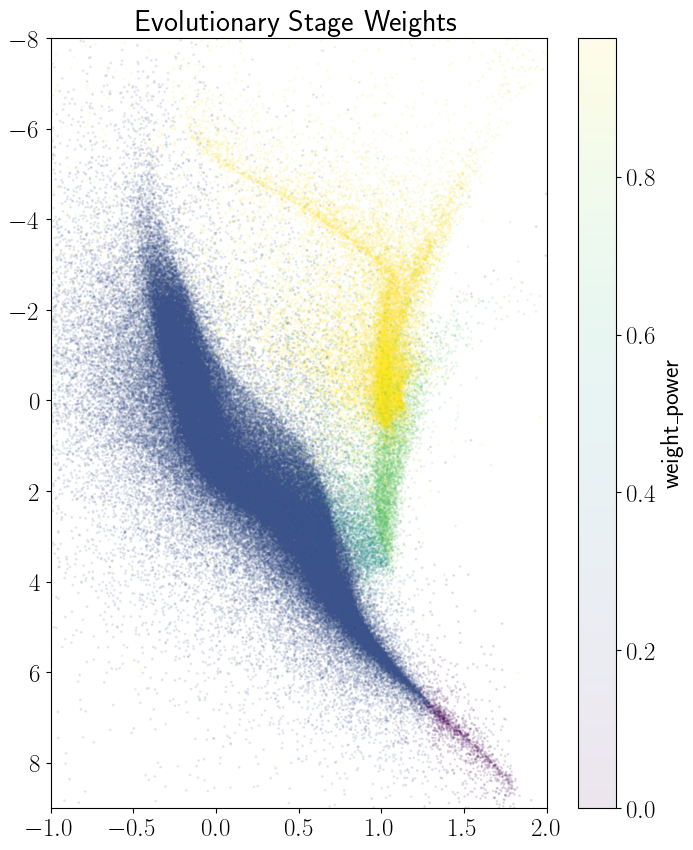

In [36]:
# Scatter plot colored by weight
plt.figure(figsize=(8, 10))
cbar = plt.scatter(speedy_sub['bp_rp_corr'], speedy_sub['implied_M_g_corr'], c=speedy_sub['weights'], s=1, alpha=0.1, cmap='viridis')
plt.gca().invert_yaxis()
plt.colorbar(cbar, label='weight_power')
plt.title('Evolutionary Stage Weights')
plt.xlim(-1, 2)
plt.ylim(9, -8)
plt.show()

<>:5: SyntaxWarning: invalid escape sequence '\k'
<>:5: SyntaxWarning: invalid escape sequence '\k'
/var/folders/__/n140hqf972zfmtt1hs5ldglw0000gn/T/ipykernel_67403/135020435.py:5: SyntaxWarning: invalid escape sequence '\k'
  plt.colorbar(cbar, label='$\kappa = 1.7 weight$')


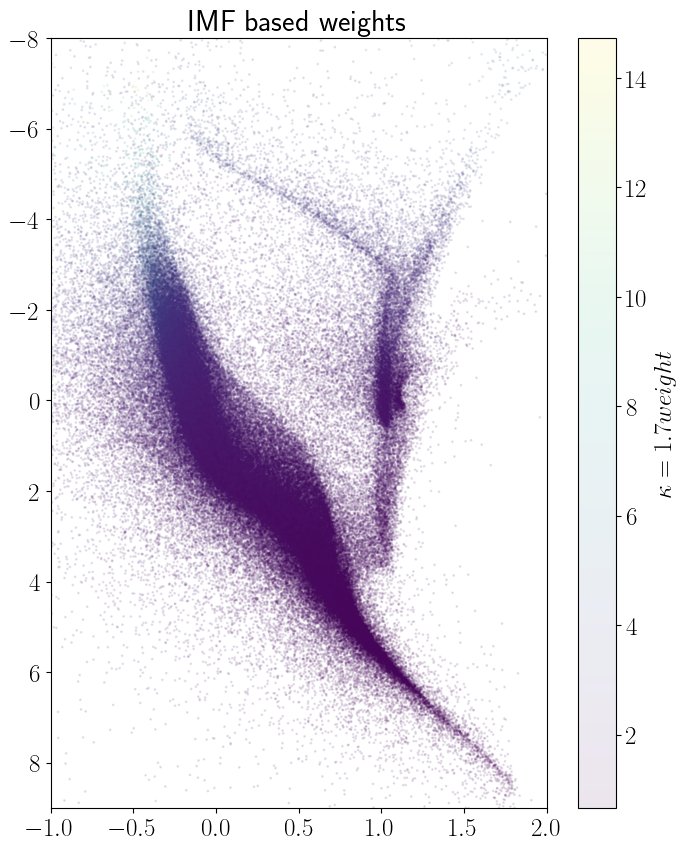

In [41]:
# Scatter plot colored by weight
plt.figure(figsize=(8, 10))
cbar = plt.scatter(speedy_sub['bp_rp_corr'], speedy_sub['implied_M_g_corr'], c=speedy_sub['weight_imf_1.7'], s=1, alpha=0.1, cmap='viridis')
plt.gca().invert_yaxis()
plt.colorbar(cbar, label='$\kappa = 1.7 weight$')
plt.title('IMF based weights')
plt.xlim(-1, 2)
plt.ylim(9, -8)
plt.show()

# SKLearn Implementation

In [117]:


kde_hvs = KernelDensity(bandwidth='scott', kernel='gaussian').fit(speedy_sub[['bp_rp_corr', 'implied_M_g_corr']])#, sample_weight=speedy_sub['weights'])



In [ ]:


#kde_hvs = KernelDensity(bandwidth='scott', kernel='gaussian').fit(speedystar[['bp_rp_corr', 'implied_M_g_corr']], sample_weight=speedystar['weights'])


# calculate log-likelihoods with the KDEs for a range of data points to plot contours
X_range = np.linspace(-1, 3, 100)
Y_range = np.linspace(15, -7, 100)
X_mesh, Y_mesh = np.meshgrid(X_range, Y_range)
XY_mesh = np.vstack([X_mesh.ravel(), Y_mesh.ravel()]).T

log_p_data_given_hvs = kde_hvs.score_samples(XY_mesh)

ValueError: cannot reshape array of size 100 into shape (50,50)

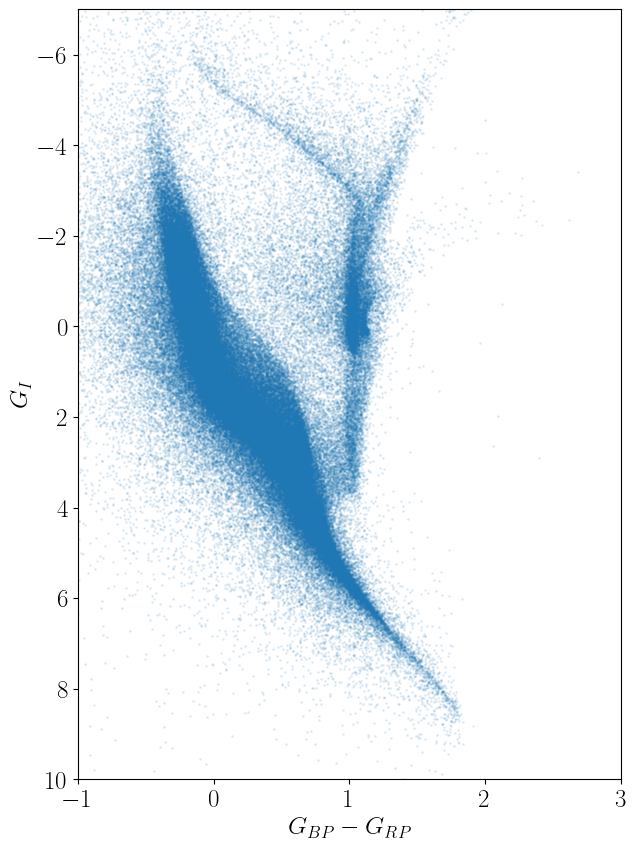

In [ ]:
# plot the CMD of the data with the KDE contours
# plot the KDE and the original data for each class
fig, ax = plt.subplots(1, 1, figsize=(7, 10))

ax.scatter(speedystar['bp_rp_corr'], speedystar['implied_M_g_corr'], s=1, alpha=0.1)

ax.set_xlabel('$G_{BP} - G_{RP}$')
ax.set_ylabel('$G_I$')
ax.set_xlim(-1, 3)
ax.set_ylim(10, -7)


cbar_1 = ax.contourf(X_mesh, Y_mesh, np.exp(log_p_data_given_hvs).reshape(100, 100),
                                 cmap='Blues', levels = 20, alpha = 0.6)

# add colorbars
fig.colorbar(cbar_1, ax=ax, label = '$P(data|hvs)$')

plt.tight_layout()
plt.show()

# Test with FFT KDE

Since the SKlearn implementation is extremely slow, I want to test a different one with FFT

In [22]:
from KDEpy.BaseKDE import BaseKDE
from KDEpy.FFTKDE import FFTKDE

In [55]:
# Initialize FFTKDE
kde = FFTKDE(kernel='gaussian', bw=0.01)

# Extract data points
data = np.array(speedy_sub[['bp_rp_corr', 'implied_M_g_corr']])

# Fit the KDE
fft_kde = kde.fit(data)

# Define the evaluation grid with ranges expanded to include all data points
x_min, x_max = data[:, 0].min(), data[:, 0].max()
y_min, y_max = data[:, 1].min(), data[:, 1].max()

print(x_min, x_max, y_min, y_max)
# Add a small margin around the data range
margin = 0.2  # Adjust this as needed
X_range = np.linspace(x_min - margin, x_max + margin, 100)
Y_range = np.linspace(y_min - margin, y_max + margin, 100)

# Create a meshgrid for evaluation
X_mesh, Y_mesh = np.meshgrid(X_range, Y_range)
XY_mesh = np.vstack([X_mesh.ravel(), Y_mesh.ravel()]).T

# Sort the grid lexicographically
sorted_indices = np.lexsort((XY_mesh[:, 1], XY_mesh[:, 0]))
XY_mesh = XY_mesh[sorted_indices]

# Evaluate the KDE
log_p_data_given_hvs = fft_kde.evaluate(XY_mesh)

-0.9999995654323293 2.9996958527535202 -6.999997438188265 9.588521665285784


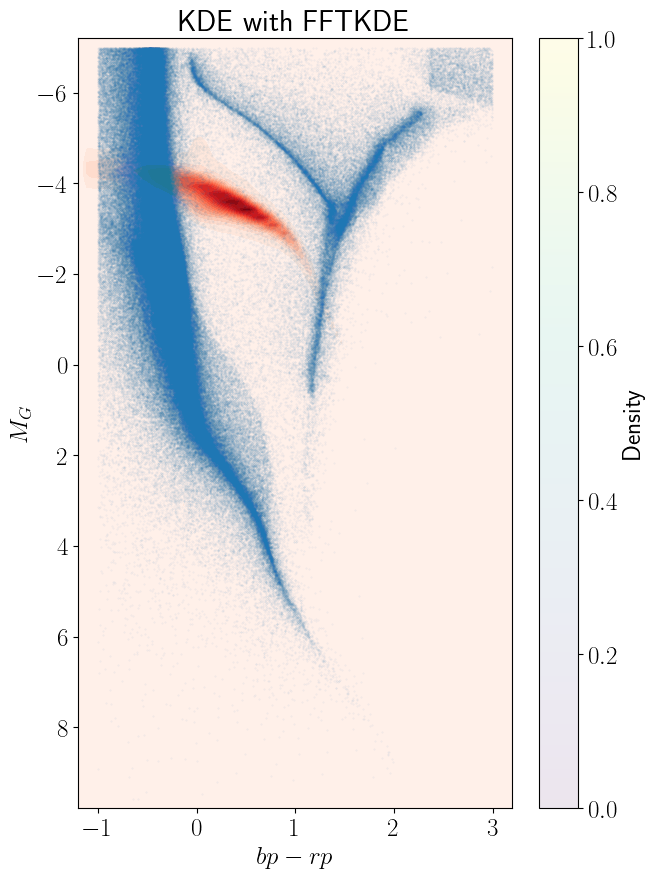

In [54]:
# Reshape for plotting
Z = log_p_data_given_hvs.reshape(len(Y_range), len(X_range))

plt.figure(figsize=(7, 10))

# Plot the KDE
plt.contourf(X_mesh, Y_mesh, Z, levels=20, cmap="Reds")
plt.scatter(speedy_sub['bp_rp_corr'], speedy_sub['implied_M_g_corr'], s=0.1, alpha=0.1)
plt.colorbar(label="Density")
plt.xlabel("$bp - rp$")
plt.ylabel("$M_G$")
plt.title("KDE with FFTKDE")
plt.gca().invert_yaxis()
plt.show()

/Users/mncavieres/opt/anaconda3/envs/speedytest2/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


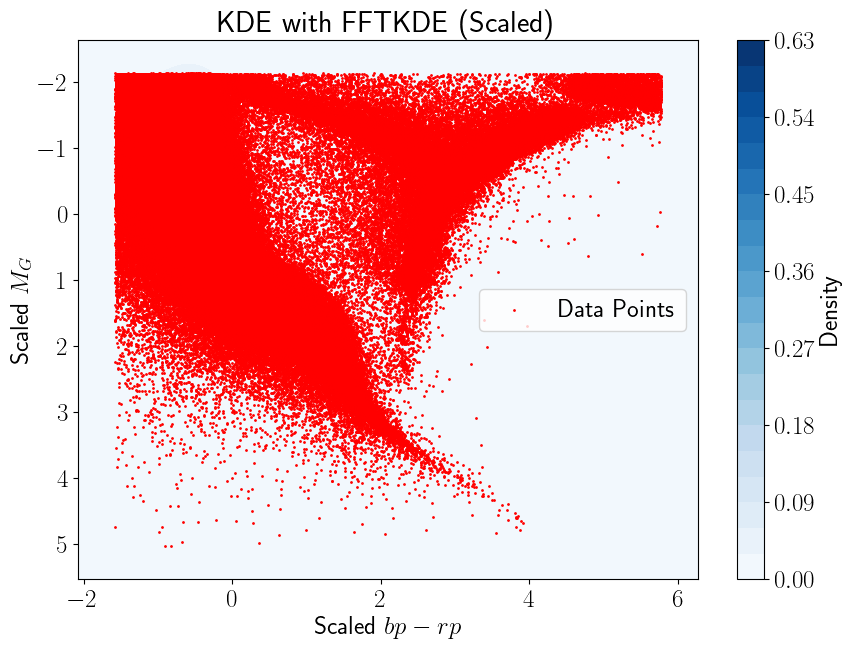

/Users/mncavieres/opt/anaconda3/envs/speedytest2/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


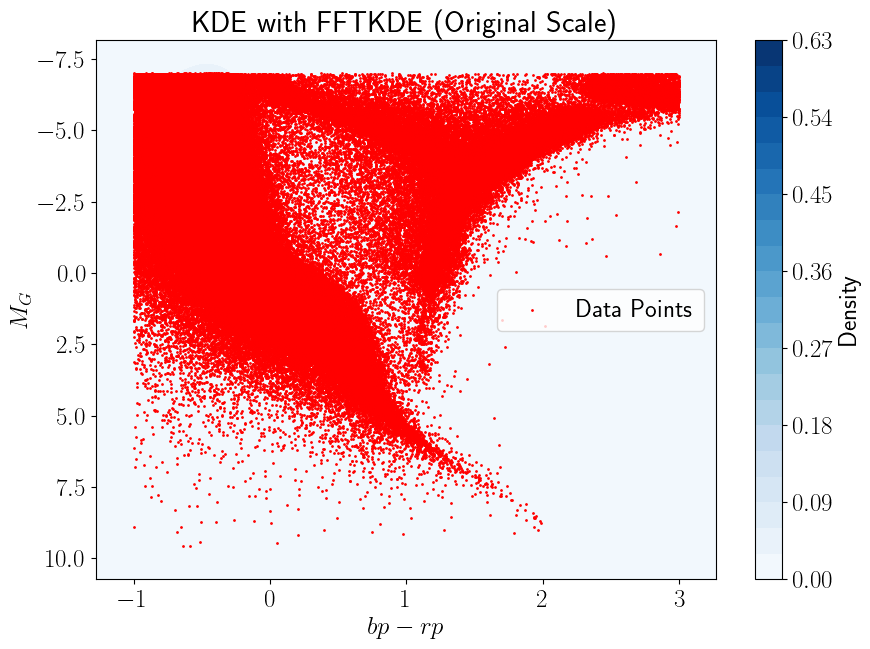

In [60]:
from KDEpy import FFTKDE
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Example data (replace with your actual DataFrame `speedystar`)
# speedystar = ...

# Extract data points
data = np.array(speedy_sub[['bp_rp_corr', 'implied_M_g_corr']])

# Scale data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Fit the KDE
kde = FFTKDE(kernel='gaussian', bw=0.2)
fft_kde = kde.fit(data_scaled)

# Define the evaluation grid
x_min, x_max = data_scaled[:, 0].min(), data_scaled[:, 0].max()
y_min, y_max = data_scaled[:, 1].min(), data_scaled[:, 1].max()
margin = 0.5
X_range = np.linspace(x_min - margin, x_max + margin, 100)
Y_range = np.linspace(y_min - margin, y_max + margin, 100)

# Create a meshgrid for evaluation
X_mesh, Y_mesh = np.meshgrid(X_range, Y_range)
XY_mesh = np.vstack([X_mesh.ravel(), Y_mesh.ravel()]).T

# Sort the grid lexicographically
sorted_indices = np.lexsort((XY_mesh[:, 1], XY_mesh[:, 0]))
XY_mesh = XY_mesh[sorted_indices]

# Evaluate the KDE
log_p_data_given_hvs = fft_kde.evaluate(XY_mesh)

# Reshape for plotting
Z = log_p_data_given_hvs[np.argsort(sorted_indices)].reshape(X_mesh.shape)

# Plot the KDE with scaled grid
plt.contourf(X_mesh, Y_mesh, Z, levels=20, cmap="Blues")
plt.colorbar(label="Density")
plt.scatter(data_scaled[:, 0], data_scaled[:, 1], color="red", s=1, label="Data Points")
plt.xlabel("Scaled $bp - rp$")
plt.ylabel("Scaled $M_G$")
plt.title("KDE with FFTKDE (Scaled)")
plt.legend()
plt.gca().invert_yaxis()
plt.show()

# Transform grid back to the original scale for plotting
X_orig, Y_orig = scaler.inverse_transform(np.column_stack([X_mesh.ravel(), Y_mesh.ravel()])).T
X_mesh_orig = X_orig.reshape(X_mesh.shape)
Y_mesh_orig = Y_orig.reshape(Y_mesh.shape)

# Plot the KDE with the original scale
plt.contourf(X_mesh_orig, Y_mesh_orig, Z, levels=20, cmap="Blues")
plt.colorbar(label="Density")
plt.scatter(data[:, 0], data[:, 1], color="red", s=1, label="Data Points")
plt.xlabel("$bp - rp$")
plt.ylabel("$M_G$")
plt.title("KDE with FFTKDE (Original Scale)")
plt.legend()
plt.gca().invert_yaxis()
plt.show()



/var/folders/__/n140hqf972zfmtt1hs5ldglw0000gn/T/ipykernel_43450/1557904860.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


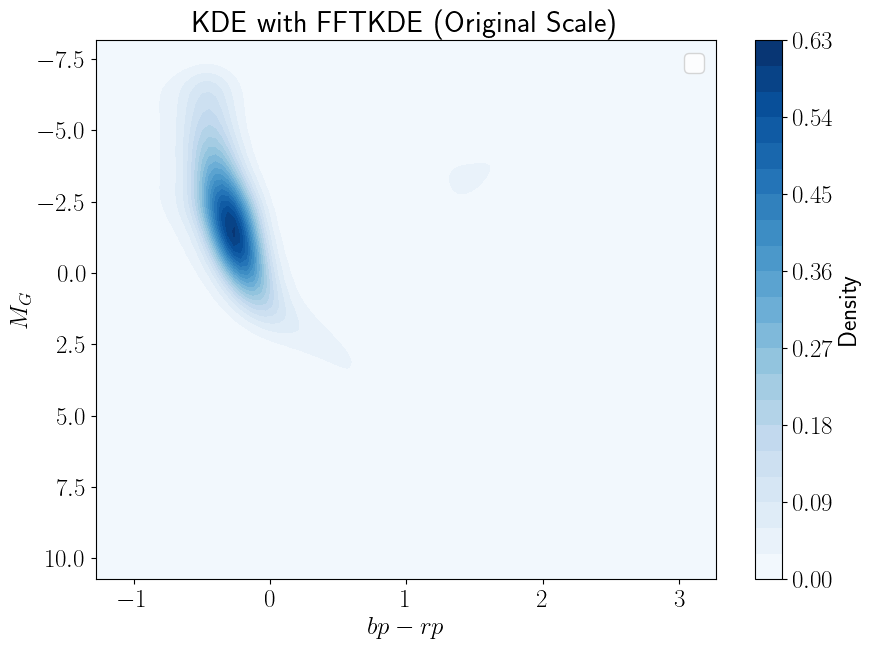

In [61]:
# Plot the KDE with the original scale
plt.contourf(X_mesh_orig, Y_mesh_orig, Z, levels=20, cmap="Blues")
plt.colorbar(label="Density")
#plt.scatter(data[:, 0], data[:, 1], color="red", s=1, label="Data Points")
plt.xlabel("$bp - rp$")
plt.ylabel("$M_G$")
plt.title("KDE with FFTKDE (Original Scale)")
plt.legend()
plt.gca().invert_yaxis()
plt.show()

# My own KDE implementation

In [51]:
from scripts.misc.fft_kde import WeightedFFTKDE

In [72]:
kde_hvs = WeightedFFTKDE(bw=0.1, grid_size=2560, margin=0.5).fit(
    speedy_sub[['bp_rp_corr', 'implied_M_g_corr']].values,
    weights=speedy_sub['weights'].values
)

In [73]:
# calculate densities with the KDE for a range of data points to plot contours
X_range = np.linspace(-1, 3, 100)
Y_range = np.linspace(15, -7, 100)
X_mesh, Y_mesh = np.meshgrid(X_range, Y_range)
XY_mesh = np.vstack([X_mesh.ravel(), Y_mesh.ravel()]).T

# Evaluate KDE densities at the grid points
densities = kde_hvs.evaluate(XY_mesh)

# make them go from 0 to 1
densities = densities/np.max(densities)


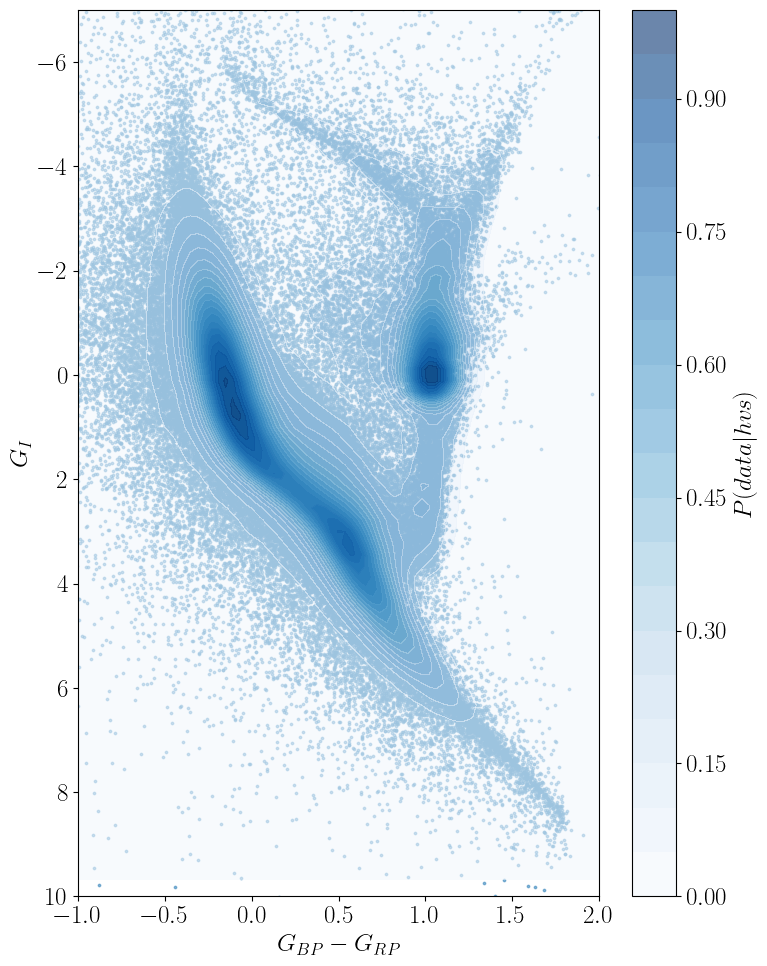

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(8, 10))

ax.scatter(speedystar['bp_rp_corr'], speedystar['implied_M_g_corr'], s=3, alpha=0.5)

ax.set_xlabel('$G_{BP} - G_{RP}$')
ax.set_ylabel('$G_{I}$')
ax.set_xlim(-1, 2)
ax.set_ylim(10, -7)

cbar_1 = ax.contourf(
    X_mesh, Y_mesh,
    densities.reshape(100, 100),
    cmap='Blues', levels=20, alpha=0.6
)

# add colorbar
fig.colorbar(cbar_1, ax=ax, label='$P(data|hvs)$')
#plt.title('$\kappa = 2.3$ \n linear weights based on Evolutionary stage')


plt.tight_layout()
plt.show()

# IMF weights

<>:35: SyntaxWarning: invalid escape sequence '\k'
<>:35: SyntaxWarning: invalid escape sequence '\k'
/var/folders/__/n140hqf972zfmtt1hs5ldglw0000gn/T/ipykernel_67403/929285105.py:35: SyntaxWarning: invalid escape sequence '\k'
  plt.title('$\kappa = 0$ \n')


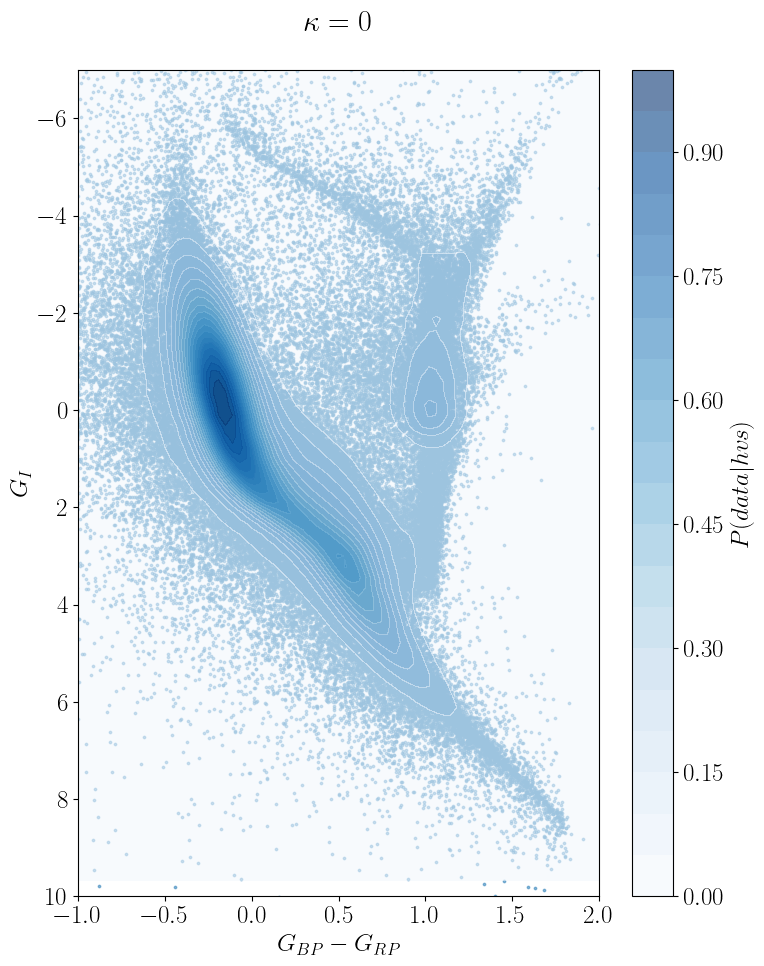

In [71]:
kde_hvs = WeightedFFTKDE(bw=0.1, grid_size=2560, margin=0.5).fit(
    speedy_sub[['bp_rp_corr', 'implied_M_g_corr']].values,
    weights=speedy_sub['weight_imf_0'].values
)

# calculate densities with the KDE for a range of data points to plot contours
X_range = np.linspace(-1, 3, 100)
Y_range = np.linspace(15, -7, 100)
X_mesh, Y_mesh = np.meshgrid(X_range, Y_range)
XY_mesh = np.vstack([X_mesh.ravel(), Y_mesh.ravel()]).T

# Evaluate KDE densities at the grid points
densities = kde_hvs.evaluate(XY_mesh)

# make them go from 0 to 1
densities = densities/np.max(densities)

fig, ax = plt.subplots(1, 1, figsize=(8, 10))

ax.scatter(speedystar['bp_rp_corr'], speedystar['implied_M_g_corr'], s=3, alpha=0.5)

ax.set_xlabel('$G_{BP} - G_{RP}$')
ax.set_ylabel('$G_{I}$')
ax.set_xlim(-1, 2)
ax.set_ylim(10, -7)

cbar_1 = ax.contourf(
    X_mesh, Y_mesh,
    densities.reshape(100, 100),
    cmap='Blues', levels=20, alpha=0.6
)

# add colorbar
fig.colorbar(cbar_1, ax=ax, label='$P(data|hvs)$')
plt.title('$\kappa = 0$ \n')


plt.tight_layout()
plt.show()


In [58]:
# real flat IMF

speedystar_flat_imf = Table.read('/Users/mncavieres/Documents/2024-2/HVS/Data/speedystar_catalogs/speedy_flat.fits')
speedystar_flat_imf = prepare_speedystar(speedystar_flat_imf)

/Users/mncavieres/opt/anaconda3/envs/speedytest2/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [63]:
# select visible by Gaia DR4
speedystar_flat_imf = speedystar_flat_imf.loc[speedystar_flat_imf['phot_g_mean_mag']< 21]
# select only point sbetween bp-rp = -1 and 3 and G_I = 10 and -7
speedystar_flat_imf_sub = speedystar_flat_imf.loc[(speedystar_flat_imf['bp_rp_corr'] > -1.2) & (speedystar_flat_imf['bp_rp_corr'] < 2) & (speedystar_flat_imf['implied_M_g_corr'] > -8) & (speedystar_flat_imf['implied_M_g_corr'] < 9)].copy()

<>:35: SyntaxWarning: invalid escape sequence '\k'
<>:35: SyntaxWarning: invalid escape sequence '\k'
/var/folders/__/n140hqf972zfmtt1hs5ldglw0000gn/T/ipykernel_67403/2425532460.py:35: SyntaxWarning: invalid escape sequence '\k'
  plt.title('$\kappa = 0$ \n')


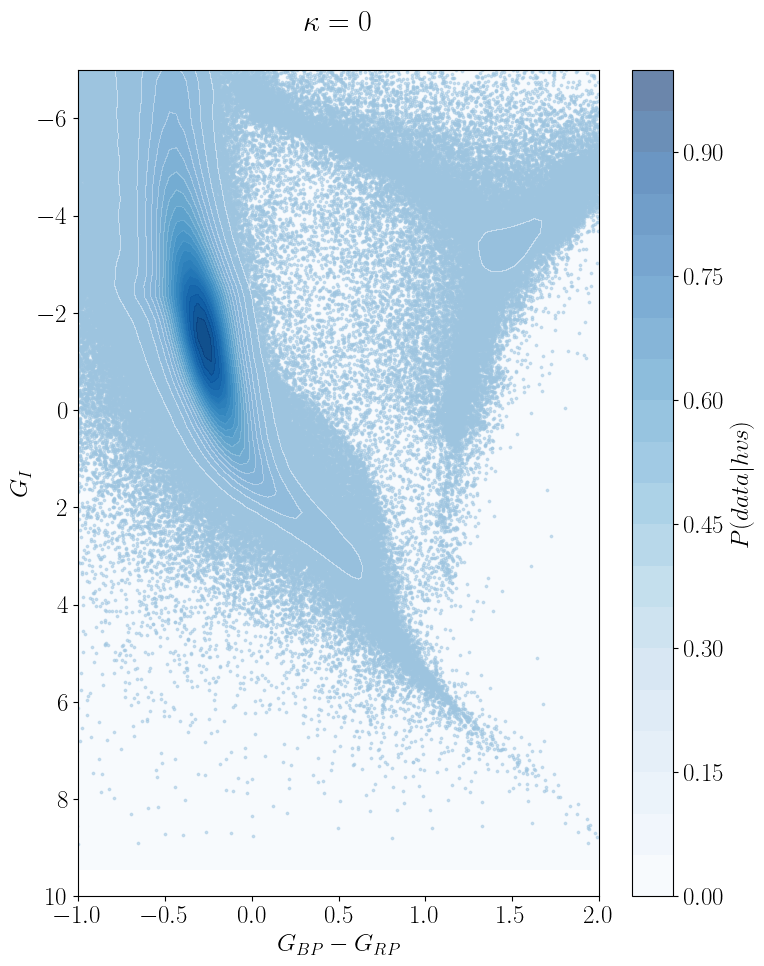

In [70]:
kde_hvs = WeightedFFTKDE(bw=0.1, grid_size=2560, margin=0.5).fit(
    speedystar_flat_imf_sub[['bp_rp_corr', 'implied_M_g_corr']].values#,
    #weights=speedystar_flat_imf['weight_imf_0'].values
)

# calculate densities with the KDE for a range of data points to plot contours
X_range = np.linspace(-1, 3, 100)
Y_range = np.linspace(15, -7, 100)
X_mesh, Y_mesh = np.meshgrid(X_range, Y_range)
XY_mesh = np.vstack([X_mesh.ravel(), Y_mesh.ravel()]).T

# Evaluate KDE densities at the grid points
densities = kde_hvs.evaluate(XY_mesh)

# make them go from 0 to 1
densities = densities/np.max(densities)

fig, ax = plt.subplots(1, 1, figsize=(8, 10))

ax.scatter(speedystar_flat_imf_sub['bp_rp_corr'], speedystar_flat_imf_sub['implied_M_g_corr'], s=3, alpha=0.5)

ax.set_xlabel('$G_{BP} - G_{RP}$')
ax.set_ylabel('$G_{I}$')
ax.set_xlim(-1, 2)
ax.set_ylim(10, -7)

cbar_1 = ax.contourf(
    X_mesh, Y_mesh,
    densities.reshape(100, 100),
    cmap='Blues', levels=20, alpha=0.6
)

# add colorbar
fig.colorbar(cbar_1, ax=ax, label='$P(data|hvs)$')
plt.title('$\kappa = 0$ \n')


plt.tight_layout()
plt.show()


$w =  M^{\alpha_{ini} - \alpha_{new}}$